In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.layers import Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
#Reading dataset and specifying variable to predict
data = pd.read_csv("merged_dataset.csv")
popularity = data["popularity"]
y_name = "popularity"
columns = data.columns

In [3]:
#Encoding the genre variable ("rock", "pop") to a factor ("0", "1")
le = preprocessing.LabelEncoder()
categorical_features = ["genre"]
data["genre_le"] = le.fit_transform(data['genre'].str.split(',').astype(str))

In [4]:
#Initializing a new variable for every genre and creating a one hot encoding
for i in range(19):
    data["genre" + str(i)] = tf.zeros(len(data))
for i in range(len(data)):
    genre = data.loc[i,"genre_le"]
    data.loc[i,"genre"+str(genre)] = 1.0

In [5]:
#Dropping all the columns we don't need
data.drop(["artist", "songname", "genre", "genre_le", "duration_ms"], axis=1, inplace=True)

In [6]:
data.head()

,year,popularity,duration_s,artist_popularity,Coleman_Liau,SMOG,trust,fear,negative,sadness,...,genre9,genre10,genre11,genre12,genre13,genre14,genre15,genre16,genre17,genre18
0,1973,20,165,80,1.968696,4.655896,0.230769,0.000000,0.000000,0.076923,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1999,4,279,80,4.241031,8.587818,0.163636,0.036364,0.036364,0.127273,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1979,34,205,80,0.815776,6.158741,0.174312,0.018349,0.064220,0.027523,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1999,2,185,80,2.278431,7.098364,0.128655,0.058480,0.175439,0.058480,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1981,20,297,80,4.602060,6.289867,0.074627,0.149254,0.268657,0.134328,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#Doing a min/max normalization on the numerical variables that are not already between [0,1]
column_names_to_normalize = ['year', 'duration_s', 'Coleman_Liau', 'SMOG','neg_sent','neutral','pos_sent']
x = data[column_names_to_normalize].values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = data.index)
data[column_names_to_normalize] = df_temp

#Doing it seperately for popularity and artist popularity since the scale should be preserved 
data.loc[:,"popularity"] = data.loc[:,"popularity"]/100
data.loc[:,"artist_popularity"] = data.loc[:,"artist_popularity"]/100

In [8]:
data.head()

,year,popularity,duration_s,artist_popularity,Coleman_Liau,SMOG,trust,fear,negative,sadness,...,genre9,genre10,genre11,genre12,genre13,genre14,genre15,genre16,genre17,genre18
0,0.465909,0.20,0.086521,0.8,0.601187,0.059761,0.230769,0.000000,0.000000,0.076923,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.761364,0.04,0.153620,0.8,0.662051,0.213664,0.163636,0.036364,0.036364,0.127273,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.534091,0.34,0.110065,0.8,0.570307,0.118585,0.174312,0.018349,0.064220,0.027523,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.761364,0.02,0.098293,0.8,0.609484,0.155364,0.128655,0.058480,0.175439,0.058480,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.556818,0.20,0.164214,0.8,0.671722,0.123718,0.074627,0.149254,0.268657,0.134328,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [9]:
#Create the input and label vector/matrices
X = data.drop([y_name], axis=1).values
y = data[y_name].values
print(X.shape)
print(y.shape)

(36889, 37)
(36889,)


In [10]:
#Simply predicting the mean of the training dataset for the test dataset
n_split = 10
basic_mae_per_fold = list()

for train_index,test_index in KFold(n_split, shuffle=True).split(X):
    
    #Creating train and test set
    y_train,y_test=popularity[train_index],popularity[test_index]
    
    #Calculating the mean over the train set
    mean_pop = np.mean(y_train)
    
    #Predicting the mean of the train set for the test set and computing the mean absolute error
    mae = np.mean(abs(y_test - mean_pop))
    
    #adding the value to list for analysis
    basic_mae_per_fold.append(mae)
    
print("The mean performance of the model over a 5-fold crossvalidation is: " + str(np.mean(basic_mae_per_fold)))
print("The standard deviation around this mean is: " + str(np.std(basic_mae_per_fold)))

The mean performance of the model over a 5-fold crossvalidation is: 12.75822015356898
The standard deviation around this mean is: 0.11874114783238619


In [276]:
#Starting the model building for a simple neural network (with 10-fold CV)
import time

n_split = 10
mae_per_fold = list()
fold_number = 1

#Measuring the time
start = time.time()
#Setting up the Cross Validation
for train_index,test_index in KFold(n_split).split(X):
    x_train,x_test=X[train_index],X[test_index]
    y_train,y_test=y[train_index],y[test_index]
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=64, input_shape=(X.shape[1], ), activation="relu"))
    #model.add(Dropout(0.20)) #erstmal ohne
    #model.add(BatchNormalization(axis=1)) #erstmal ohne
    model.add(tf.keras.layers.Dense(units=32, activation="relu"))
    model.add(tf.keras.layers.Dense(units=1))
    
    optimizer = tf.keras.optimizers.RMSprop()
    
    model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.MeanAbsoluteError()#, 
              #metrics=[tf.keras.metrics.MeanAbsoluteError()])
             )
    
    print("Training in fold number: " + str(fold_number))
    print()
    
    history = model.fit(x=x_train,
                    y=y_train,
                    epochs = 50,
                    batch_size=64,
                    validation_split = 0.2,
                    callbacks=[EarlyStopping(patience=10, verbose=2)])
    
    print()
    print("Evaluate on test data")
    result = model.evaluate(x_test, y_test, batch_size=64)*100
    print("Mean Absolute Error on the Test Dataset:", result)
    print()
    mae_per_fold.append(result)
    fold_number += 1

end = time.time()
print(end - start)

Training in fold number: 1

Epoch 1/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1157 - val_loss: 0.1110
Epoch 2/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1107 - val_loss: 0.1098
Epoch 3/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1100 - val_loss: 0.1054
Epoch 4/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1089 - val_loss: 0.1153
Epoch 5/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1085 - val_loss: 0.1057
Epoch 6/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1080 - val_loss: 0.1086
Epoch 7/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1076 - val_loss: 0.1073
Epoch 8/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1073 - val_loss: 0.1061
Epoch 9/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1070 - val_loss: 0.1046
Epoch 10/50
415/415 [==============================] - 1s 1ms/step - los

415/415 [==============================] - 1s 1ms/step - loss: 0.1093 - val_loss: 0.1058
Epoch 8/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1087 - val_loss: 0.1062
Epoch 9/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1082 - val_loss: 0.1072
Epoch 10/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1080 - val_loss: 0.1112
Epoch 11/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1078 - val_loss: 0.1069
Epoch 12/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1078 - val_loss: 0.1133
Epoch 13/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1074 - val_loss: 0.1045
Epoch 14/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1071 - val_loss: 0.1083
Epoch 15/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1071 - val_loss: 0.1093
Epoch 16/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1067 - val_loss: 0.1109
Epoc

Epoch 14/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1050 - val_loss: 0.1052
Epoch 15/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1049 - val_loss: 0.1128
Epoch 16/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1047 - val_loss: 0.1076
Epoch 17/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1046 - val_loss: 0.1064
Epoch 18/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1044 - val_loss: 0.1084
Epoch 19/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1042 - val_loss: 0.1128
Epoch 20/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1039 - val_loss: 0.1099
Epoch 21/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1038 - val_loss: 0.1080
Epoch 22/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1037 - val_loss: 0.1062
Epoch 23/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1036 - val_los

Epoch 21/50
415/415 [==============================] - 0s 1ms/step - loss: 0.1038 - val_loss: 0.1181
Epoch 22/50
415/415 [==============================] - 0s 1ms/step - loss: 0.1039 - val_loss: 0.1163
Epoch 23/50
415/415 [==============================] - 0s 1ms/step - loss: 0.1037 - val_loss: 0.1176
Epoch 24/50
415/415 [==============================] - 0s 1ms/step - loss: 0.1035 - val_loss: 0.1185
Epoch 25/50
415/415 [==============================] - 0s 1ms/step - loss: 0.1034 - val_loss: 0.1171
Epoch 26/50
415/415 [==============================] - 0s 1ms/step - loss: 0.1033 - val_loss: 0.1171
Epoch 27/50
415/415 [==============================] - 1s 1ms/step - loss: 0.1034 - val_loss: 0.1192
Epoch 28/50
415/415 [==============================] - 0s 1ms/step - loss: 0.1032 - val_loss: 0.1169
Epoch 29/50
415/415 [==============================] - 0s 1ms/step - loss: 0.1030 - val_loss: 0.1153
Epoch 30/50
415/415 [==============================] - 0s 1ms/step - loss: 0.1028 - val_los

In [277]:
#Performance of the model
mae_10_fold = np.mean(mae_per_fold)
sd_10_fold = np.std(mae_per_fold)

print("The mean performance of the model over a 10-fold crossvalidation is: " + str(mae_10_fold))
print("The standard deviation around this mean is: " + str(sd_10_fold))

The mean performance of the model over a 10-fold crossvalidation is: 11.186323761940002
The standard deviation around this mean is: 0.5878109238374408


Text(0, 0.5, 'Computation time in seconds')

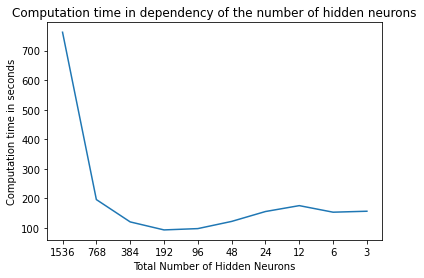

In [12]:
#Computation time with the different amount of hidden neurons (with early stopping)
time = [762.15, 195.59, 120, 92.88, 97.31, 121.66, 155.15, 175.1, 152.88, 156.14]
number_hidden_neurons = ["1536","768","384","192","96","48","24","12","6","3"]
plt.plot(number_hidden_neurons,time)
plt.title("Computation time in dependency of the number of hidden neurons")
plt.xlabel("Total Number of Hidden Neurons")
plt.ylabel("Computation time in seconds")

Text(0, 0.5, 'Mean Absolute Error')

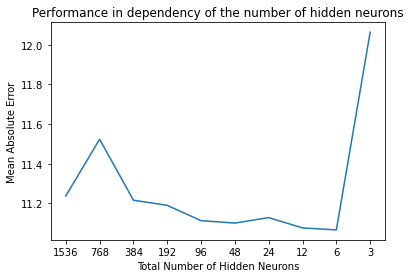

In [272]:
# This code just helped to create the graphic "Performance in dependency of the number of hidden neurons"
# # cv_mae_neurons = list()
# # cv_sd_neurons = list()

# cv_mae_neurons.append(mae_10_fold)
# cv_sd_neurons.append(sd_10_fold)

# number_hidden_neurons = ["1536","768","384","192","96","48","24","12","6","3"]
# number_hidden_neurons

# plt.plot(number_hidden_neurons,cv_mae_neurons)
# plt.title("Performance in dependency of the number of hidden neurons")
# plt.xlabel("Total Number of Hidden Neurons")
# plt.ylabel("Mean Absolute Error")

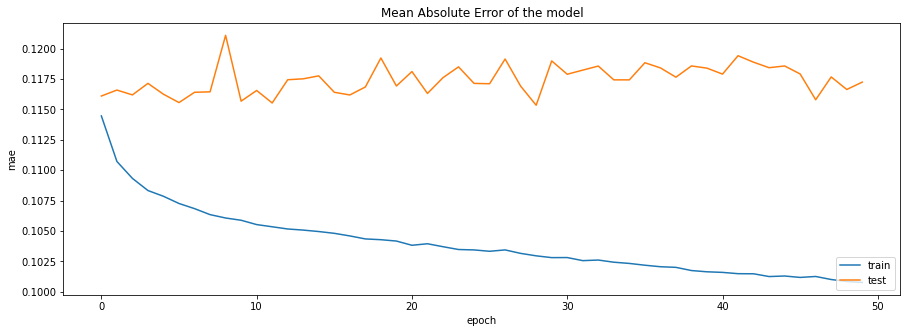

In [278]:
#Plotting the training and test progression over the epochs of the last fold
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(15,5))
plt.plot(loss)
plt.plot(val_loss)
plt.title('Mean Absolute Error of the model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()